In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input,DepthwiseConv2D, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape,ReLU,AvgPool2D)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from tensorflow.keras.applications import VGG19
from keras.applications.vgg19 import VGG19,preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
train_directory='/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train'
validation_directory='/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test'

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IMAGE_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 30,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "Class_Names": ["angry", "happy", "sad"],
}
    


## **Dataset Loading**

In [4]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',#If the picture is angry then (1 0 0), if the picture is sad, then (0 1 0), if happy then (0 0 1)
    class_names=CONFIGURATION["Class_Names"], #Class_Names vary so its better to declare a variable and manually create a list and insert the classes name.
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"],CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
)
val_dataset=tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["Class_Names"], #Class_Names vary so its better to declare a variable and manually create a list and insert the classes name.
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"],CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [5]:
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

## **Data Visualization**

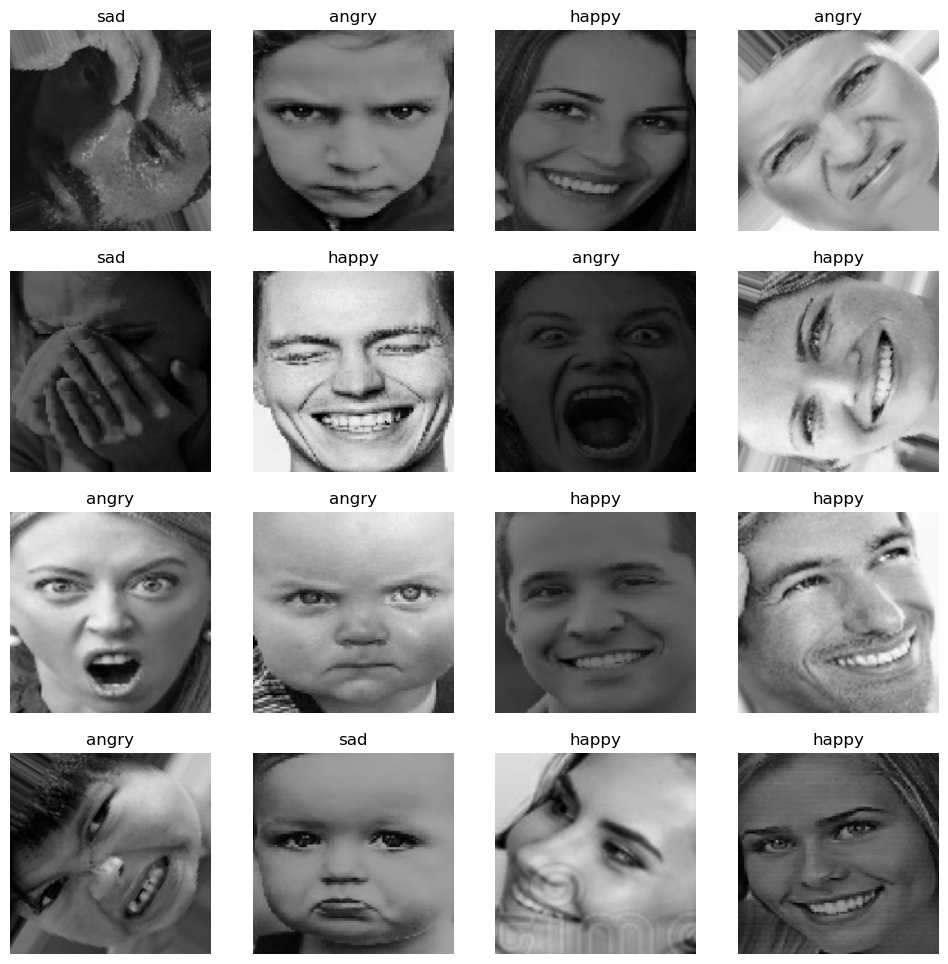

In [6]:
plt.figure(figsize=(12,12))
for images,labels in train_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title(CONFIGURATION["Class_Names"][tf.argmax(labels[i],axis=0).numpy()])
        plt.axis("off")

## **Data Augmentation**

In [7]:
augment_layers=tf.keras.Sequential([
    RandomRotation(factor=(-0.025,0.025),),
    RandomFlip(mode="horizontal"),
    RandomContrast(factor=0.1),
])

In [8]:
def augment_layer(image,label):
    return augment_layers(image,training=True),label

### **Cutmix Augmentation**

In [9]:
def box(lamda):
    r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IMAGE_SIZE"]).sample(1)[0], dtype = tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IMAGE_SIZE"]).sample(1)[0], dtype = tf.int32)

    r_w = tf.cast(CONFIGURATION["IMAGE_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
    r_h = tf.cast(CONFIGURATION["IMAGE_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

    r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IMAGE_SIZE"])
    r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IMAGE_SIZE"])

    x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IMAGE_SIZE"])
    y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IMAGE_SIZE"])

    r_w = x_b_r - r_x
    if(r_w == 0):
        r_w  = 1

    r_h = y_b_r - r_y
    if(r_h == 0):
        
        r_h = 1

    return r_y, r_x, r_h, r_w

In [10]:
def cutmix(train_dataset_1, train_dataset_2):
    (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

    lamda = tfp.distributions.Beta(2,2)
    lamda = lamda.sample(1)[0]
  
    r_y, r_x, r_h, r_w = box(lamda)
    crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
    pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"])

    crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
    pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"])

    image = image_1 - pad_1 + pad_2

    lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IMAGE_SIZE"]*CONFIGURATION["IMAGE_SIZE"]), dtype = tf.float32)
    label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

    return image, label

In [11]:
# train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
# train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
# mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [12]:
'''training_dataset = (
    train_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE))
validation_dataset=(
    val_dataset
    .prefetch(tf.data.AUTOTUNE))'''

'training_dataset = (\n    train_dataset\n    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)\n    .prefetch(tf.data.AUTOTUNE))\nvalidation_dataset=(\n    val_dataset\n    .prefetch(tf.data.AUTOTUNE))'

## **Dataset Preparation**

In [13]:
training_dataset=(
    train_dataset
    .map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE))
validation_dataset=(
    val_dataset
    .prefetch(tf.data.AUTOTUNE))

In [14]:
resize_rescale_layers=tf.keras.Sequential([
    Resizing(CONFIGURATION["IMAGE_SIZE"],CONFIGURATION["IMAGE_SIZE"]),
    Rescaling(1./255)
])

In [15]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None,None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

## **Training**

In [16]:
loss_function=CategoricalCrossentropy(from_logits=False) #Since its softmax activation, we are putting it false, else it shold have been true

**Standalone Code**

In [17]:
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
# Using 'auto'/'sum_over_batch_size' reduction type.
cce = tf.keras.losses.CategoricalCrossentropy()
print(cce(y_true, y_pred).numpy())

1.1769392


In [18]:
metrics=[CategoricalAccuracy(name="accuracy"),TopKCategoricalAccuracy(k=2,name="top_k_accuracy")]

In [19]:
callpoint=ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True,)

In [23]:
lenet_model.compile(
optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss=loss_function,
    metrics=metrics,)

In [25]:
history=lenet_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=20,
    verbose=1,
    callbacks=[callpoint]
)

212/213 [============================>.] - ETA: 0s - loss: 0.5176 - accuracy: 0.7874 - top_k_accuracy: 0.9450
Epoch 1: val_accuracy did not improve from 0.73047
213/213 [==============================] - 49s 230ms/step - loss: 0.5172 - accuracy: 0.7875 - top_k_accuracy: 0.9451 - val_loss: 0.8683 - val_accuracy: 0.6435 - val_top_k_accuracy: 0.8819


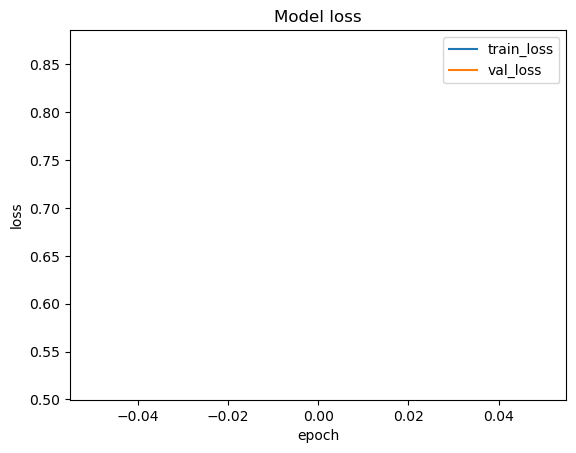

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

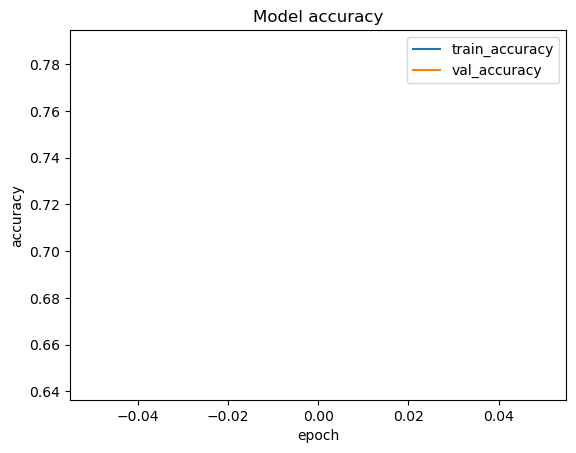

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [30]:
lenet_model.load_weights('best_weights')

In [31]:
lenet_model.evaluate(validation_dataset)

72/72 [==============================] - 4s 53ms/step - loss: 0.6627 - accuracy: 0.7305 - top_k_accuracy: 0.9118


[0.6626565456390381, 0.730465292930603, 0.9117646813392639]

In [40]:
lenet_model.save('lenet.h5')

## **Testing**

In [41]:
test_image=cv2.imread("/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/happy/110020.jpg")
im=tf.constant(test_image,dtype=tf.float32)
im=tf.expand_dims(im,axis=0)
print(CONFIGURATION["Class_Names"][tf.argmax(lenet_model(im),axis=-1).numpy()[0]])

happy


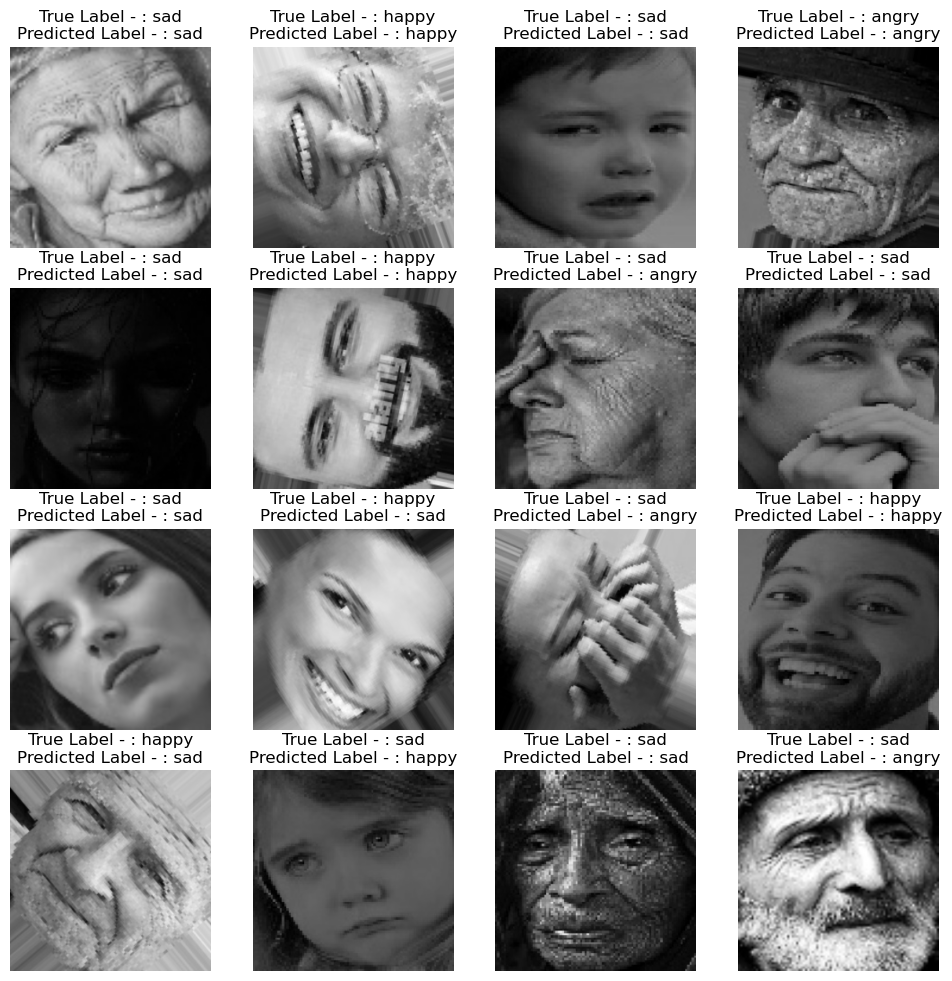

In [42]:
plt.figure(figsize=(12,12))
for images,labels in validation_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title("True Label - : " + CONFIGURATION["Class_Names"][tf.argmax(labels[i], axis = -1).numpy()] 
              + "\n" + "Predicted Label - : " 
              + CONFIGURATION["Class_Names"][int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
       
        plt.axis("off")

## **Confusion Matrix**

In [43]:
predicted = []
labels = []
for im, label in validation_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())

In [44]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[2 1 2 ... 2 2 1]
[1 0 1 ... 2 2 1]


In [45]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[357  72  86]
 [ 98 807 101]
 [149 108 500]]


Text(0.5, 58.7222222222222, 'Predicted')

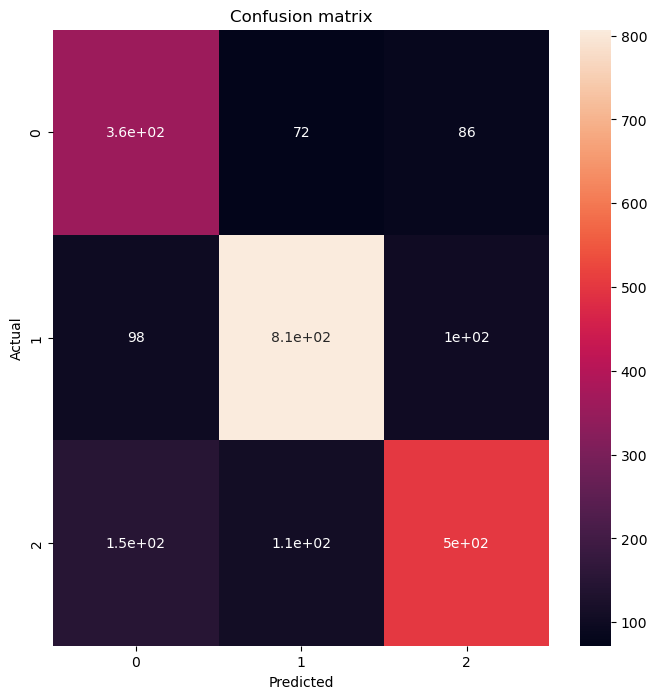

In [46]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [48]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 55.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 6.8 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.1-py3-none-any.whl size=5596 sha256=785110667c78a5ea7ff4733bd95f86d533df90daa7f5e7e370e0329d1841fabf
  Stored in directory: /root/.cache/pip/wheels/01/a6/d1/1c0828c304a4283b2c1639a09ad86f83d7c487ef34c6b4a1bf
Successfully built ffmpy


## **AlexNet**

In [56]:
alexnet_model=keras.models.Sequential([
    InputLayer(input_shape = (None,None, 3), ),
    resize_rescale_layers,
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax")  
])
alexnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       46592     
                                                                 
 batch_normalization_4 (Batc  (None, 62, 62, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 31, 31, 256)       819456    
                                                                 
 batch_normalization_5 (Batc  (None, 31, 31, 256)     

In [ ]:
alexnet_model.compile(
optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss=loss_function,
    metrics=metrics)

In [ ]:
history=alexnet_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=CONFIGURATION["N_EPOCHS"],
    verbose=1,
)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
alexnet_model.evaluate(validation_dataset)

In [ ]:
alaexnet_model.save('alexnet.h5')

In [ ]:
plt.figure(figsize=(12,12))
for images,labels in validation_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title("True Label - : " + CONFIGURATION["Class_Names"][tf.argmax(labels[i], axis = -1).numpy()] 
              + "\n" + "Predicted Label - : " 
              + CONFIGURATION["Class_Names"][int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
       
        plt.axis("off")

In [ ]:
predicted = []
labels = []
for im, label in validation_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## **VGGNet**

In [ ]:
'''IMAGE_SIZE = [ 224 , 224 , 3 ] 
vgg = VGG19( include_top = False,
            input_shape = IMAGE_SIZE,
            weights = 'imagenet')
for  layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)
prediction = Dense( CONFIGURATION["NUM_CLASSES"] , activation = 'softmax' )(x)
VGG_19_model = Model( inputs = vgg.input , outputs = prediction )
VGG_19_model.summary()'''

In [ ]:
'''VGG_19_model.compile(
optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss=loss_function,
    metrics=metrics)'''

In [ ]:
'''train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input ,
    fill_mode = 'nearest'
)'''

In [ ]:
#train_path='/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train'
# test_path='/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test'

In [ ]:
'''train_set = train_datagen.flow_from_directory(train_path,
                                            target_size = ( 224 , 224 ),
                                            batch_size = 32,
                                            class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                             target_size = ( 224 , 224 ),
                                            batch_size = 32,
                                            class_mode = 'categorical')'''

In [ ]:
'''model_history = VGG_19_model.fit( train_set,
                          validation_data = test_set,
                          epochs = 20,
                          verbose = 1)'''

In [ ]:
'''plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()'''

In [ ]:
'''plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()'''

In [ ]:
#VGG_19_model.evaluate(test_set)

In [ ]:
'''plt.figure(figsize=(12,12))
for images,labels in test_set.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title("True Label - : " + CONFIGURATION["Class_Names"][tf.argmax(labels[i], axis = -1).numpy()] 
              + "\n" + "Predicted Label - : " 
              + CONFIGURATION["Class_Names"][int(tf.argmax(VGG_19_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
       
        plt.axis("off")'''

In [ ]:
'''predicted = []
labels = []
for im, label in validation_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
cm = confusion_matrix(lab, pred)
print(cm)6
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')'''

## **ResNet**

### **Custom Conv2D**

In [ ]:
class CustomConv2D(Layer):
    def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
        super(CustomConv2D, self).__init__(name = 'custom_conv2d')
        self.conv = Conv2D(
            filters = n_filters,
            kernel_size = kernel_size,
            activation = 'relu',
            strides = n_strides,
            padding = padding)
        self.batch_norm = BatchNormalization()
    def call(self, x, training = True):
        
        x = self.conv(x)
        x = self.batch_norm(x, training)
        return x
     


### **Residual Block**

In [ ]:
class ResidualBlock(Layer):
    def __init__(self, n_channels, n_strides = 1):
        super(ResidualBlock, self).__init__(name = 'res_block')

        self.dotted = (n_strides != 1)

        self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
        self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

        self.activation = Activation('relu')

        if self.dotted:
            self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)
    def call(self, input, training):
        x = self.custom_conv_1(input, training)
        x = self.custom_conv_2(x, training)

        if self.dotted:
            x_add = self.custom_conv_3(input, training)
            x_add = Add()([x, x_add])
        else:
            x_add = Add()([x, input])

        return self.activation(x_add)

In [ ]:
class ResNet34(Model):
    def __init__(self,):
        super(ResNet34, self).__init__(name = 'resnet_34')
        self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
        self.max_pool = MaxPooling2D(3,2)
    
        self.conv_2_1 = ResidualBlock(64)
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)
    
        self.conv_3_1 = ResidualBlock(128, 2)
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        self.conv_3_4 = ResidualBlock(128)

        self.conv_4_1 = ResidualBlock(256, 2)
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        self.conv_4_4 = ResidualBlock(256)
        self.conv_4_5 = ResidualBlock(256)
        self.conv_4_6 = ResidualBlock(256)
    
        self.conv_5_1 = ResidualBlock(512, 2)
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)

        self.global_pool = GlobalAveragePooling2D()

        self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')
    def call(self, x, training = True):
        x = self.conv_1(x)
        x = self.max_pool(x)

        x = self.conv_2_1(x, training)
        x = self.conv_2_2(x, training)
        x = self.conv_2_3(x, training)
    
        x = self.conv_3_1(x, training)
        x = self.conv_3_2(x, training)
        x = self.conv_3_3(x, training)
        x = self.conv_3_4(x, training)
    
        x = self.conv_4_1(x, training)
        x = self.conv_4_2(x, training)
        x = self.conv_4_3(x, training)
        x = self.conv_4_4(x, training)
        x = self.conv_4_5(x, training)
        x = self.conv_4_6(x, training)
    
        x = self.conv_5_1(x, training)
        x = self.conv_5_2(x, training)
        x = self.conv_5_3(x, training)

        x = self.global_pool(x)
    
        return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

In [ ]:
callpoint=ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True,)

In [ ]:
resnet_34.compile(
optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']*10),
loss=loss_function,
metrics=metrics)


In [ ]:
history=resnet_34.fit(training_dataset,
                     validation_data=validation_dataset,
                     epochs=CONFIGURATION['N_EPOCHS']*3,
                     verbose=1,
                     callbacks=[callpoint],
                     )

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()'''

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
resnet_34.load_weights('best_weights')

In [ ]:
resnet_34.evaluate(validation_dataset)

In [ ]:
tf.saved_model.save(resnet_34,'/kaggle/working/')

In [ ]:
plt.figure(figsize=(12,12))
for images,labels in validation_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title("True Label - : " + CONFIGURATION["Class_Names"][tf.argmax(labels[i], axis = -1).numpy()] 
              + "\n" + "Predicted Label - : " 
              + CONFIGURATION["Class_Names"][int(tf.argmax(VGG_19_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
       
        plt.axis("off")

In [ ]:
predicted = []
labels = []
for im, label in validation_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
cm = confusion_matrix(lab, pred)
print(cm)6
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## **MobileNet**

In [ ]:
backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"], 3),
    )
backbone.trainable = False     
pretrainedmobil_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),
    
    ])
# pretrainedmobil_model.summary()

In [ ]:
pretrainedmobil_model.compile(
optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']*10),
loss=loss_function,
metrics=metrics)

In [ ]:
history=pretrainedmobil_model.fit(training_dataset,
                     validation_data=validation_dataset,
                     epochs=CONFIGURATION['N_EPOCHS'],
                     verbose=1,
                     callbacks=[callpoint],
                     )

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
pretrainedmobil_model.load_weights('best_weights')

In [ ]:
pretrainedmobil_model.evaluate(validation_dataset)

In [ ]:
pretrainedmobil_model.save('mobilnet.h5')

In [ ]:
plt.figure(figsize=(12,12))
for images,labels in validation_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title("True Label - : " + CONFIGURATION["Class_Names"][tf.argmax(labels[i], axis = -1).numpy()] 
              + "\n" + "Predicted Label - : " 
              + CONFIGURATION["Class_Names"][int(tf.argmax(pretrainedmobil_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
       
        plt.axis("off")

In [ ]:
predicted = []
labels = []
for im, label in validation_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## **EfficientNet**

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"], 3),
    )
     
backbone.trainable = False
     
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),
    
    ])
pretrained_model.summary()

### **Fine-Tuning EfficientNet**

In [ ]:
backbone.trainable = True

input = Input(shape = (CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"],3))
x = backbone(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)
finetuned_model = Model(input, output)
finetuned_model.summary()